# Regression
The regression problem is about finding a function $f(x; w)$ given example input vectors $x_i$ and corresponding outputs $y_i$ for $i=1,\dots, N$. 

The collection $\{x_i, y_i\}$ for $i=1\dots N$ is called a _data set_. 

The mapping $f$ is a function of inputs and possibly some parameters $w$. 

If the mapping $f$ is linear in $w$, the problem is a __Linear Regression__ problem.

Note that the mapping $f$ itself does not need to be linear in $x$. The linearity in $w$ is sufficient to call the problem a linear regression. 

## Linearity:
A function $g$ is linear when
$$
g(aw_1 + b w_2) = a g(w_1) + b g(w_2)
$$
for all scalar $a,b$ and vectors $w_1$ and $w_2$.



## Example: Line Fitting

* We wish to fit a line to data where we are given pairs
$$
(y_i, x_i)
$$
for $i=1\dots N$ (or $i=0\dots N-1$)

* Model
$$
y_i \approx f(x; w_1, w_0) = w_0 + w_1 x 
$$


>  $x$ : Input 

>  $w_1$: The slope

>  $w_0$: Intercept

$f_i \equiv f(x_i; w_1, w_0)$


### Example Dataset

Number of registered cars in Turkey, as a function of years.

|$i$|$y_i$|$x_i$|
|-------------|
|Index|Number of Cars (In Millions)|Year|


In [5]:
%matplotlib inline

import scipy as sc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt

df_arac = pd.read_csv(u'data/arac.csv',sep=';')
df_arac[['Year','Car']]

,Year,Car
0,1966,91469
1,1967,112367
2,1968,125375
3,1969,137345
4,1970,137771
5,1971,153676
6,1972,187272
7,1973,240360
8,1974,313160
9,1975,403546


## Visualizing the data

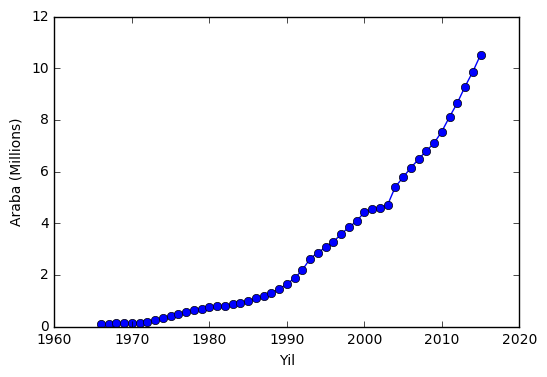

In [7]:
BaseYear = 1995
x = np.matrix(df_arac.Year[0:]).T-BaseYear
y = np.matrix(df_arac.Car[0:]).T/1000000.

plt.plot(x+BaseYear, y, 'o-')
plt.xlabel('Yil')
plt.ylabel('Araba (Millions)')

plt.show()

### Manual Model Fitting

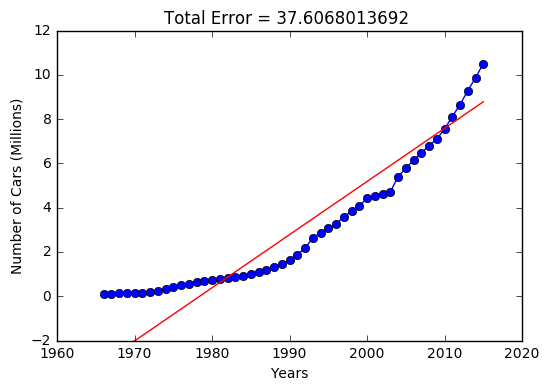

In [9]:
%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.pylab as plt
from IPython.display import clear_output, display, HTML


w_0 = 0.27150786
w_1 = 0.37332256

BaseYear = 1995
x = np.matrix(df_arac.Year[0:]).T-BaseYear
y = np.matrix(df_arac.Car[0:]).T/1000000.

fig, ax = plt.subplots()

f = w_1*x + w_0
plt.plot(x+BaseYear, y, 'o-')
ln, = plt.plot(x+BaseYear, f, 'r')


plt.xlabel('Years')
plt.ylabel('Number of Cars (Millions)')
ax.set_ylim((-2,12))
plt.close(fig)

def set_line(w_1, w_0):

    f = w_1*x + w_0
    e = y - f

    ln.set_ydata(f)
    ax.set_title('Total Error = {} '.format(np.asscalar(e.T*e/2)))
    display(fig)

interact(set_line, w_1=(-2, 2, 0.01), w_0=(-5, 5, 0.01))


* Fitting the model: estimating $w = [w_0, w_1]$

* As there is noise, we can't hope to fit our model exactly

* Define the error for each observation 

$$e_i = \frac{1}{2}(y_i - f(x_i; w))^2$$

squared Euclidian norm. The constant $1/2$ is useful for a cosmetical simplification.

* Total Error (sum over all data points)

$$
E(w) = \frac{1}{2} \sum_i (y_i - f(x_i; w))^2
$$

* We can minimize the total error by adjusting $w_0$ and $w_1$

### Visualization of the error surface

A good approach for low dimensional problems is the visualization of the error surface. We evaluate her exhaustively the error for each possible  setting of the parameter $w$. 

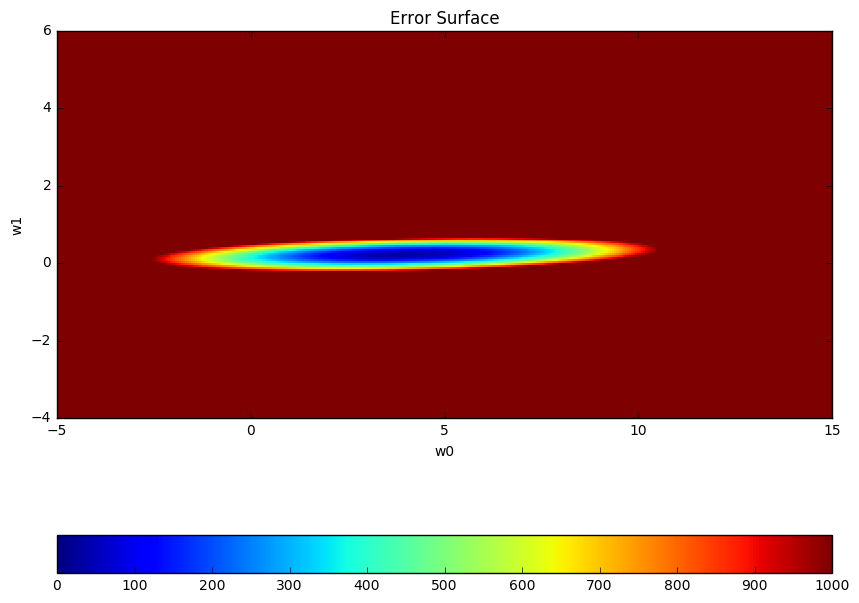

In [10]:
from itertools import product

# Setup the vandermonde matrix
N = len(x)
A = np.hstack((np.ones((N,1)), x))

left = -5
right = 15
bottom = -4
top = 6
step = 0.05
W0 = np.arange(left,right, step)
W1 = np.arange(bottom,top, step)

ErrSurf = np.zeros((len(W1),len(W0)))

for i,j in product(range(len(W1)), range(len(W0))):
    e = y - A*np.matrix([W0[j], W1[i]]).T
    ErrSurf[i,j] = e.T*e/2

plt.figure(figsize=(10,10))
plt.imshow(ErrSurf, interpolation='nearest', 
           vmin=0, vmax=1000,origin='lower',
           extent=(left,right,bottom,top))
plt.xlabel('w0')
plt.ylabel('w1')
plt.title('Error Surface')
plt.colorbar(orientation='horizontal')
plt.show()

# How to fit the model automatically?

## Idea: Least Squares

* Compute the derivative of the total error w.r.t. $w_0$ and $w_1$ and solve the equations
* Derivation in Vector Notation

\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{cc}
1 & x_0 \\ 1 & x_1 \\ \vdots \\ 1 & x_{N-1}  
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  
\end{array}
\right)
\end{eqnarray}

\begin{eqnarray}
y \approx A w
\end{eqnarray}

> $A = A(x)$: Design Matrix

> $w$: Model Parameters

> $y$: Observations

* Error vector: $$e = y - Aw$$

\begin{eqnarray}
E(w) & = & \frac{1}{2}e^\top e = \frac{1}{2}(y - Aw)^\top (y - Aw)\\
& = & \frac{1}{2}y^\top y - \frac{1}{2} y^\top Aw - \frac{1}{2} w^\top A^\top y + \frac{1}{2} w^\top A^\top Aw \\
& = & \frac{1}{2} y^\top y - y^\top Aw + \frac{1}{2} w^\top A^\top Aw \\
\end{eqnarray}

### Gradient
Derivative of the function $E$ with respect to a vector 
\begin{eqnarray}
\frac{d E}{d w } & = & \left(\begin{array}{c}
 \partial E/\partial w_0 \\ \partial E/\partial w_1 \\ \vdots \\  \partial E/\partial w_{K-1}
\end{array}\right)
\end{eqnarray}
  
We derive the gradient of the total error as
\begin{eqnarray}
\frac{d}{d w }E(w) & = & \frac{d}{d w }(\frac{1}{2} y^\top y) &+ \frac{d}{d w }(- y^\top Aw) &+ \frac{d}{d w }(\frac{1}{2} w^\top A^\top Aw) \\
& = & 0 &- A^\top y &+ A^\top A w \\
& = & - A^\top (y - Aw) \\
& = & - A^\top e \\
& \equiv & \nabla E(w)
\end{eqnarray}

#### Two basic results everyone must know
* Gradient of an inner product
\begin{eqnarray}
\frac{d}{d w }(h^\top w) & = & h
\end{eqnarray}

* Gradient of a Quadratic form
\begin{eqnarray}
\frac{d}{d w }(w^\top K w) & = & (K+K^\top) w
\end{eqnarray}


### Least Squares solution: Directly solving the equations 
* Find

\begin{eqnarray}
w^* & = & \arg\min_{w} E(w)
\end{eqnarray}

* Optimality Condition (from basic Calculus, the gradient should vanish)

\begin{eqnarray}
\nabla E(w^*) & = & 0
\end{eqnarray}


* Set the derivative to zero and solve for $w^*$

\begin{eqnarray}
0 & = & - A^\top y + A^\top A w^*  \\
A^\top y & = &  A^\top A w^* \\
w^* & = & (A^\top A)^{-1} A^\top y 
\end{eqnarray}

* Projection interpretation:

\begin{eqnarray}
f & = A w^*  = A (A^\top A)^{-1} A^\top y 
\end{eqnarray}

$P$ is the orthogonal projection matrix onto the space spanned by the columns of $A$
\begin{eqnarray}
P & = & A (A^\top A)^{-1} A^\top 
\end{eqnarray}

To understand the last equation, consider the case when $A$ is a column vector. The projector is
\begin{eqnarray}
P & = & \frac{A}{\|A\|} \frac{A^\top}{\|A\|} 
\end{eqnarray}
Hence the approximation is given by 
\begin{eqnarray}
f & = A w^*  = \frac{A}{\|A\|} \left( \frac{A^\top}{\|A\|} y \right)
\end{eqnarray}
This expression clearly project the vector $y$ onto the unit vector pointing in the direction of $A$.

Parameters: 
w0 =  [[ 3.94060309]] 
w1 =  [[ 0.194523]]
Error: [[ 26.15676891]]


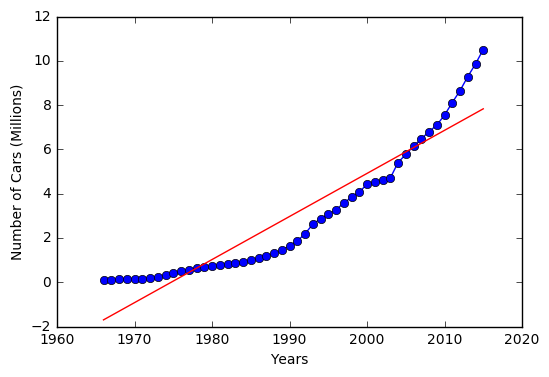

In [17]:
# Solving the Normal Equations

# Setup the Design matrix
N = len(x)
A = np.hstack((np.ones((N,1)), x))

#plt.imshow(A, interpolation='nearest')
# Solve the least squares problem
w_ls,E,rank,sigma = np.linalg.lstsq(A, y)

print('Parameters: \nw0 = ', w_ls[0],'\nw1 = ', w_ls[1] )
print('Error:', E/2)

f = np.asscalar(w_ls[1])*x + np.asscalar(w_ls[0])
plt.plot(x+BaseYear, y, 'o-')
plt.plot(x+BaseYear, f, 'r')


plt.xlabel('Years')
plt.ylabel('Number of Cars (Millions)')
plt.show()

### Iterative Solution: Gradient Descent (GD)

* Here, we can iteratively search for better solutions by moving in the negative direction of the gradient

* Iterate until convergence 
\begin{align}
w(0) & = \text{some initial value} \\
\text{for}\;\; & \tau = 1, 2,\dots \\
& w(\tau) = w(\tau-1) - \eta \nabla E(w(\tau-1))
\end{align}

* $\eta$ is the learning rate parameter, to be chosen sufficiently small

* For solving linear systems, GD is a quite poor algorithm. However, it is applicable to many other problems so it is a good idea to know about it and learn it in this context.


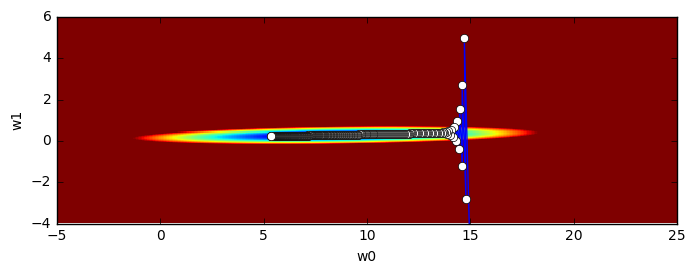

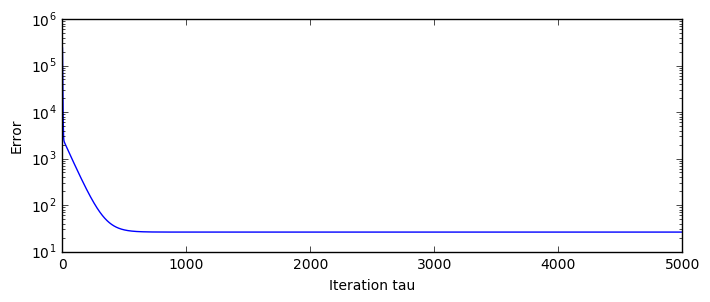

In [29]:
# An implementation of Gradient Descent for solving linear a system

left = -5
right = 25
bottom = -4
top = 6

# Setup the Design matrix
N = len(x)
A = np.hstack((np.ones((N,1)), x))

# Starting point
w = np.matrix('[15; -6]')

# Number of iterations
EPOCH = 5000

# Learning rate: The following is the largest possible fixed rate for this problem
#eta = 0.0001696
eta = 0.0001496

Error = np.zeros((EPOCH))
W = np.zeros((2,EPOCH))

for tau in range(EPOCH):
    # Calculate the error
    e = y - A*w    
    
    # Store the intermediate results
    W[0,tau] = w[0]
    W[1,tau] = w[1]
    Error[tau] = (e.T*e)/2
    
    # Compute the gradient descent step
    g = -A.T*e
    w = w - eta*g
    #print(w.T)
    
w_star = w    
plt.figure(figsize=(8,8))
plt.imshow(ErrSurf, interpolation='nearest', 
           vmin=0, vmax=1000,origin='lower',
           extent=(left,right,bottom,top))
plt.xlabel('w0')
plt.ylabel('w1')

ln = plt.Line2D(W[0,:300:1], W[1,:300:1], marker='o',markerfacecolor='w')

plt.gca().add_line(ln)
plt.show()

plt.figure(figsize=(8,3))
plt.semilogy(Error)
plt.xlabel('Iteration tau')
plt.ylabel('Error')
plt.show()


* The illustration shows the convergence of GD with learning rate near the limit where the convergence is oscillatory.

* $\eta$, Learning rate is a parameter of the algorithm

* $w$, the variable are the parameters of the Model 

* $y$: Targets

* $x$: Inputs, 

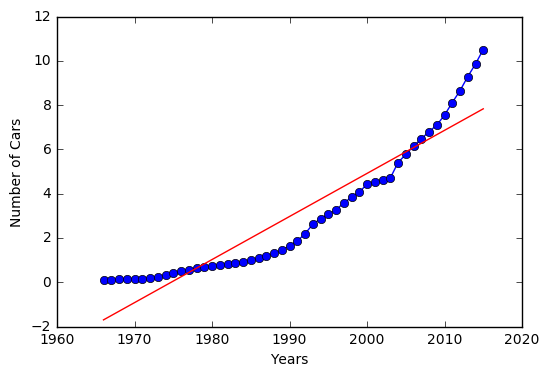

Total Error =  26.156768907362196


In [31]:
#f = A*w_ls

f = A*w_star
plt.plot(x+BaseYear, y, 'o-')
plt.plot(x+BaseYear, f, 'r')

plt.xlabel('Years')
plt.ylabel('Number of Cars')

plt.show()

e = y - f

print('Total Error = ', np.asscalar(e.T*e/2))

## Fitting a polynomial 

Often, fitting a line between inputs and outputs is not enough. A good candidate is fitting a higher order polynomial. 

### Parabola
\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{ccc}
1 & x_0 & x_0^2 \\ 1 & x_1 & x_1^2 \\ \vdots \\ 1 & x_{N-1} & x_{N-1}^2   
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  \\ w_2
\end{array}
\right)
\end{eqnarray}

### Polynomial of order $K$
\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{ccccc}
1 & x_0 & x_0^2 & \dots & x_0^K \\ 1 & x_1 & x_1^2 & \dots & x_1^K\\ \vdots \\ 1 & x_{N-1} & x_{N-1}^2 & \dots & x_{N-1}^K  
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  \\ w_2 \\ \vdots \\ w_K
\end{array}
\right)
\end{eqnarray}

The model is identical

\begin{eqnarray}
y \approx A w
\end{eqnarray}

> $A = A(x)$: Design Matrix

> $w$: Model Parameters

> $y$: Observations

Design matrices for polynomial fitting are also known as __Vandermonde__ matrices.

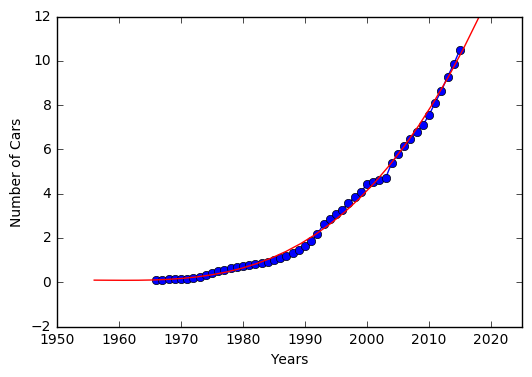

In [39]:
# Setup the vandermonde matrix
N = len(x)
degree = 3
#A = np.hstack((np.power(x,0), np.power(x,1), np.power(x,2)))
A = np.hstack((np.power(x,i) for i in range(degree+1)))
xx = np.matrix(np.linspace(np.asscalar(x[0])-10,np.asscalar(x[-1])+10,30)).T
A2 = np.hstack((np.power(xx,i) for i in range(degree+1)))

#plt.imshow(A, interpolation='nearest')
# Solve the least squares problem
w_ls,E,rank,sigma = np.linalg.lstsq(A, y)

f = A2*w_ls
plt.plot(x+BaseYear, y, 'o-')
plt.plot(xx+BaseYear, f, 'r')

plt.xlabel('Years')
plt.ylabel('Number of Cars')

plt.gca().set_ylim((-2,12))
plt.gca().set_xlim((1950,2025))

plt.show()


## AR Models 

Idea: Use past values of a time series as inputs. 
\begin{eqnarray}
y_k & = & w_1 y_{k-1} + w_2 y_{k-2} + w_3 y_{k-3} + \dots + w_L y_{k-L} + \epsilon_k
\end{eqnarray}

The design matrix consists of past values of the process. Such a design matrix is also known as a Toeplitz matrix.
\begin{eqnarray}
\left(
\begin{array}{c}
y_L \\
\vdots \\
y_k \\ y_{k+1} \\ \vdots \\ y_{N} 
\end{array}
\right)
\approx
\left(
\begin{array}{ccccc}
y_{L-1} & y_{L-2} & y_{L-3} & \dots & y_{0}\\
\vdots \\
y_{k-1} & y_{k-2} & y_{k-3} & \dots & y_{k-L} \\ y_{k} & y_{k-1} & y_{k-2} & \dots & y_{k-L+1} \\ \vdots \\ 
y_{N-1} & y_{N-2} & y_{N-3} & \dots & y_{N-L}  
\end{array}
\right) 
\left(
\begin{array}{c}
 w_1  \\ w_2 \\ w_3 \\ \vdots \\ w_L
\end{array}
\right)
\end{eqnarray}



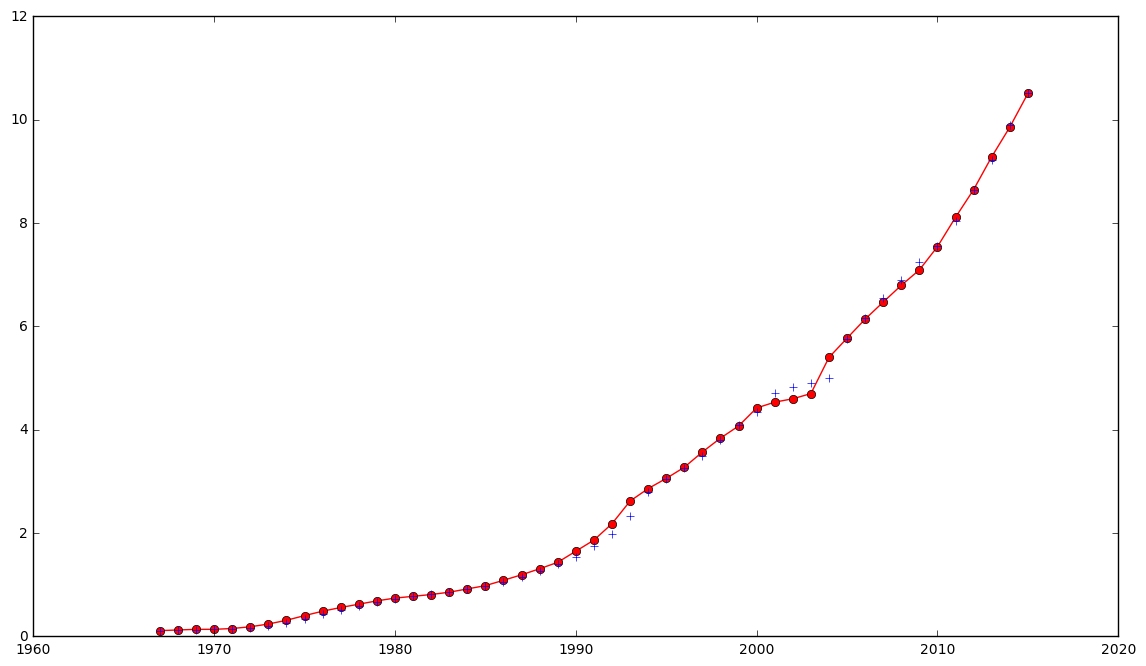

In [57]:
import scipy as sc
import scipy.linalg as la

# Order
L = 1

BaseYear = 1995
x = np.matrix(df_arac.Year[0:]).T-BaseYear
y = np.matrix(df_arac.Car[0:]).T/1000000


def AR_model(y,L):
    N = len(y) - L
    A = np.hstack((np.matrix(y[L-i:L-i+N]) for i in range(1,L+1) ))
    yy = np.matrix(y[L:(L+N+1)])
    return A, yy
   
def make_AR_model(y, L):
    B = la.toeplitz(y[:-1], y[0:L])
    AA = B[L-1:,:]
    yy = y[L:]
    return AA, yy

A,yy = AR_model(y, L)
#plt.imshow(A, interpolation='nearest')
# Solve the least squares problem
w_ls,E,rank,sigma = np.linalg.lstsq(A, yy)

f = A*w_ls

plt.figure(figsize=(14,8))
plt.plot(x[L:]+BaseYear, yy, 'o-r')
plt.plot(x[L:]+BaseYear, f, '+b')
plt.show()

In [56]:
y = np.mat([1,2,3,4,5,6,7]).T

L = 2
A, yy = AR_model(y,L)
print('Order',L)
print(A)
print(yy)

L = 5
A, yy = AR_model(y,5)
print('Order',L)
print(A)
print(yy)

Order 2
[[2 1]
 [3 2]
 [4 3]
 [5 4]
 [6 5]]
[[3]
 [4]
 [5]
 [6]
 [7]]
Order 5
[[5 4 3 2 1]
 [6 5 4 3 2]]
[[6]
 [7]]


[[  2.000e+00]
 [  2.000e+00]
 [ -8.877e-10]
 [  1.244e-10]]


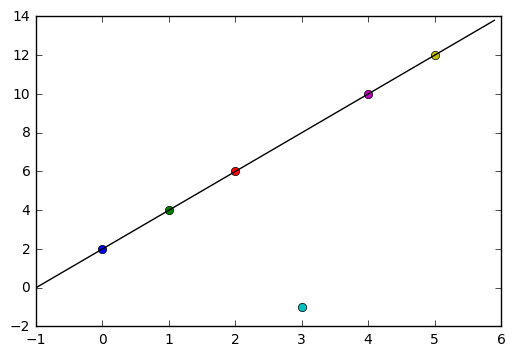

In [2]:
%matplotlib inline
#from cvxpy import *
import cvxpy as cvx
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt

np.set_printoptions(precision=3)

x = np.matrix('[0,1,2,3,4,5]').T
xx = np.matrix(np.arange(-1,6,0.1)).T
y = np.matrix('[2,4,6,-1,10,12]').T
N = len(x)
degree = 3
#A = np.hstack((np.power(x,0), np.power(x,1), np.power(x,2)))
A = np.hstack((np.power(x,i) for i in range(degree+1)))
A2 = np.hstack((np.power(xx,i) for i in range(degree+1)))


# Construct the problem.
w = cvx.Variable(degree+1)
objective = cvx.Minimize(cvx.norm(A*w - y, 1.0))
#constraints = [0 <= x, x <= 10]
#prob = Problem(objective, constraints)
prob = cvx.Problem(objective)

# The optimal objective is returned by prob.solve().
result = prob.solve()
# The optimal value for x is stored in x.value.
print(w.value)
# The optimal Lagrange multiplier for a constraint
# is stored in constraint.dual_value.
#print(constraints[0].dual_value)

plt.plot(x.T.tolist(), y.T.tolist(), 'o')
plt.plot(xx, A2*w.value, '-')
plt.show()

# Advanced Material

## Analysis of convergence of Gradient descent

Let the gradient be
$\nabla E(w) = g(w)$

We have already derived that
$g(w) = A^\top (Aw - y)$

For constant $\eta$, GD executes the following iteration

$$
w_t = w_{t-1} - \eta g(w_{t-1})
$$


$$
w_t  =  (I - \eta A^\top A) w_{t-1} + \eta A^\top y
$$

This is a fixed point equation of form
$$
w_t  =  T(w_{t-1}) 
$$
where $T$ is an affine transformation. 

We will investigate under which conditions $T$ becomes a contraction, i.e. for two different
parameter $w$ and $w'$

$$
\| T(w) - T(w') \| \leq L_\eta \|w-w' \|
$$

if $L_\eta < 1$, then the distance shrinks. Hence the mapping converges to a fixed point (this is a consequence of a deeper result in analysis called the Brouwer fixed-point theorem (https://en.wikipedia.org/wiki/Brouwer_fixed-point_theorem))

$$
T(w)   =  (I - \eta A^\top A) w + \eta A^\top y
$$
$$
T(w')   =  (I - \eta A^\top A) w' + \eta A^\top y
$$

$$
\| T(w) - T(w') \| = \| (I - \eta A^\top A) (w-w') \| \leq \| I - \eta A^\top A \| \| w-w' \|
$$

When the norm of the matrix $\| I - \eta A^\top A \| < 1$ we have convergence. Here we take the operator norm, i.e., the magnitude of the largest eigenvalue.

Below, we plot the absolute value of the maximum eigenvalues of $I - \eta A^\top A$ as a function of $\eta$.

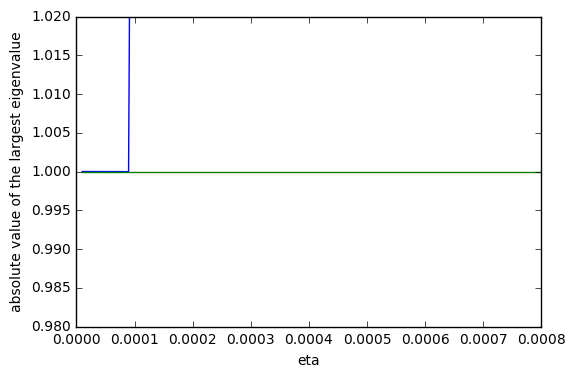

In [3]:

left = 0.00001
right = 0.0008
stp = 0.000005

N = 100
ETA = np.linspace(left,right,N)

def compute_largest_eig(ETA, A):
    
    N = len(ETA)
    LAM = np.zeros(N)
    D = A.shape[1]
    
    for i,eta in enumerate(ETA):
        #print(eta)
        lam,v = np.linalg.eig(np.eye(D) - eta*A.T*A)
        LAM[i] = np.max(np.abs(lam))
        
    return LAM

LAM = compute_largest_eig(ETA, A)

plt.plot(ETA, LAM)
plt.plot(ETA, np.ones((N,1)))
plt.gca().set_ylim([0.98, 1.02])
plt.xlabel('eta')
plt.ylabel('absolute value of the largest eigenvalue')
plt.show()



* Note that GD is sensetive to scaling of data
* For example, if we would not have shifted the $x$ axis our original data, GD might not have worked. The maximum eigenvalue is very close to $1$ for all $\eta$ upto numerical precision

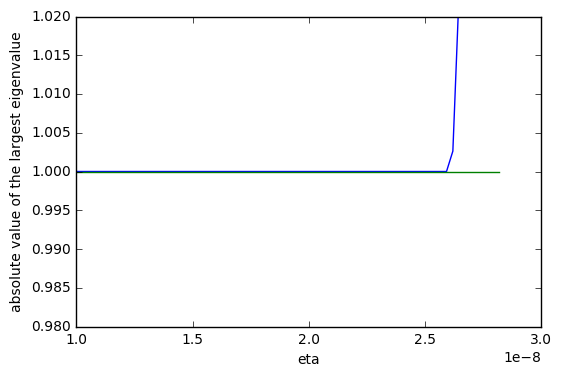

In [33]:
# Try to fit with GD to the original data
BaseYear2 = 0
x2 = np.matrix(df_arac.Year[31:]).T-BaseYear2

# Setup the vandermonde matrix
N = len(x2)
A = np.hstack((np.ones((N,1)), x2))

left = -8
right = -7.55
N = 100
ETA = np.logspace(left,right,N)

LAM = compute_largest_eig(ETA, A)

plt.plot(ETA, LAM)
plt.plot(ETA, np.ones((N,1)))
plt.gca().set_ylim([0.98, 1.02])
plt.xlabel('eta')
plt.ylabel('absolute value of the largest eigenvalue')
plt.show()

